# Image Retrieval using Pretrained ResNet-50

## Imports

In [1]:
%pip install numpy torch torchvision matplotlib tqdm pillow seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from PIL import Image
from seaborn import heatmap

### Enable CUDA

In [3]:
device = torch.device("cuda") \
    if torch.cuda.is_available() \
    else torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


# Dataset

In [4]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

batch_size = 128

def get_image_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size)
    numberof_images = 0
    mean, std = 0, 0

    for batch, _, _ in tqdm.tqdm(loader, unit="batch"):
        batch = batch.view(batch.size(0), batch.size(1), -1)

        numberof_images += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    return mean / numberof_images, std / numberof_images

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize=False):
    x = unnormalize(x)
    
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    
    return x

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is not None:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)                
])

class_label_lookup = {
    "02691156": "plane", # planes
    "02828884": "bench", # benches
    "02933112": "cupboard", # cupboards/wardrobes
    "02958343": "car", # cars
    "03001627": "chair", # chairs
    "03211117": "computer", # computers
    "03636649": "lamp", # lamps
    "03691459": "speaker", # speakers
    "04090263": "gun", # guns
    "04256520": "sofa", # sofas
    "04379243": "table", # tables/desks
    "04401088": "phone", # phones
    "04530566": "boat"  # boats
}

class ImageFolderWithImagePath(datasets.ImageFolder):
    def __getitem__(self, index):
        image, _ = super().__getitem__(index)
        path = self.imgs[index][0]

        code = path.split("/")[1]
        label = class_label_lookup[code]
        
        return image, label, path

### Load ImageNet-200

In [6]:
imagenet_dataset = ImageFolderWithImagePath('/datasets/tiny-imagenet-200/train', transform=transform)

In [ ]:
mean, std = get_image_mean_and_std(imagenet_dataset)
print(f"Mean: {mean}\nStd. Deviation: {std}")

### Reducing Dataset Size

In [ ]:
imagenet_size = len(imagenet_dataset)
print(f"Size of imagenet: {imagenet_size} images.")

imagenet_reduced_size = imagenet_size // 1
unused_imagenet_size = imagenet_size - imagenet_reduced_size
imagenet_reduced_dataset, _ = random_split(imagenet_dataset, (imagenet_reduced_size, unused_imagenet_size))

print(f"Size of reduced imagenet: {len(imagenet_reduced_dataset)} images.")

### Shuffling and Splitting Dataset

In [7]:
ratios = (0.7, 0.1, 0.2)

sizes = list(map(lambda x: round(len(imagenet_reduced_dataset) * x), ratios))
if sum(sizes) < len(imagenet_reduced_dataset):
      sizes[0] += len(imagenet_reduced_dataset) - sum(sizes)

print(f"Dataset sizes: {tuple(sizes)}")

[train, test, db] = random_split(imagenet_reduced_dataset, sizes)

print(f"Dataset Lengths:"
      f"\n\tTrain: {len(train)},"
      f"\n\tTest: {len(test)},"
      f"\n\tDatabase: {len(db)}")

loader_train = DataLoader(train, batch_size=batch_size)
loader_test = DataLoader(test, batch_size=1)

loader_database = DataLoader(db, batch_size=batch_size)

Size of tiny-imagenet-200:
	train: 100000
	test: 10000
	validation: 10000
Dimensions of a single image: (3, 224, 224)


## Algorithm

### Pre-trained ResNet-50

In [10]:
# Load Pretrained ResNet-50 from ImageNet-1K
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
model.fc = nn.Identity()

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### PCA Algorithm

### Search Algorithm

In [24]:
def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, label, path = embedding
    return cosine_similarity(target, vector), label, path

def get_similarities(target_image, embeddings):
    target_image_transformed = target_image.unsqueeze(0).to(device)
    target_embedding = model(target_image_transformed).squeeze(0)
    target_embedding = target_embedding.cpu().detach().numpy()
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    
    return sorted(similarity, key=itemgetter(0), reverse=True)

def get_closest_match(target_image, embeddings):
    return get_similarities(target_image, embeddings)[0]

## Evaluation

In [12]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### t-SNE Plot

In [ ]:
label_colour_lookup = {
    "plane": "#E53935", # planes
    "bench": "#D81B60", # benches
    "cupboard": "#8E24AA", # cupboards/wardrobes
    "car": "#5E35B1", # cars
    "chair": "#3949AB", # chairs
    "computer": "#1E88E5", # computers
    "lamp": "#039BE5", # lamps
    "speaker": "#00ACC1", # speakers
    "gun": "#00897B", # guns
    "sofa": "#43A047", # sofas
    "table": "#FF7F50", # tables/desks
    "phone": "#9FE2BF", # phones
    "boat": "#CCCCFF"  # boats
}

batches = list()
z_colours = list()

batch_iterable = iter(loader_test)

for _ in range(10):
    images, labels, paths = next(batch_iterable)
    mean, _ = model(images.to(device))
    z = mean.cpu().detach().numpy()

    z_colours.extend(list(map(label_colour_lookup.get, labels)))

    batches.append(z)

z = np.vstack(tuple(batches))

z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()
figure.set_size_inches(7, 5)

axis.scatter(list(z_reduced_x), list(z_reduced_y), c=z_colours)

## Query Test

### Create Embeddings Database

In [13]:
embeddings_database = list()

for images, _, paths in tqdm.tqdm(loader_database, unit="batch"):
    images = images.to(device)
    embeddings = model(images).cpu().detach().numpy()
    embeddings_database.extend(list(zip(embeddings, labels, paths)))

100%|██████████| 155/155 [07:19<00:00,  2.83s/batch]


In [14]:
test_embedding, test_label, test_path = embeddings_database[0]
print(test_embedding.shape, test_label, test_path)

(2048,) /datasets/tiny-imagenet-200/test/images/test_1952.JPEG


### Run Query

Similarity: 0.7581325769424438
Similarity: 0.7368459701538086
Similarity: 0.7343133687973022
Similarity: 0.7197193503379822


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


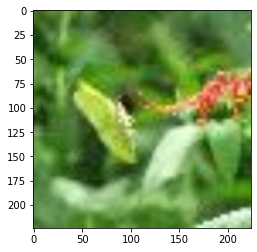

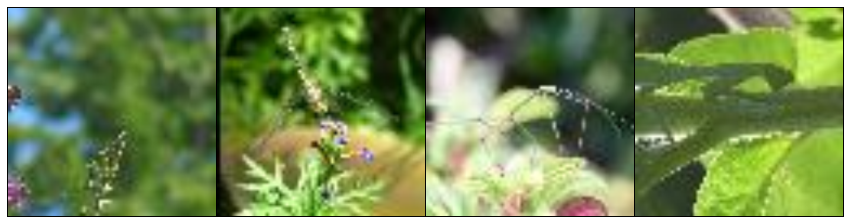

In [25]:
target, _, _ = random.choice(loader_test.dataset)
results = get_similarities(target, embeddings_database)

figure, axis = plt.subplots()
figure.set_size_inches(5, 5)
axis.set_axis_off()

show(unnormalize(target), axis=axis)

good_matches = list()

for i, (similarity, label, path) in enumerate(results[:5]):
    print(f"Similarity (closest image {i+1}): {similarity:.4f} ({label})")
    image = Image.open(path).convert("RGB")
    image = unnormalize(transform(image)).unsqueeze(0)

    good_matches.append(image.cpu())

good_matches = torch.vstack(good_matches)
good_matches = make_grid(good_matches, nrow=5, padding=1, normalize=False,
                         range=None, scale_each=False, pad_value=0)

good_figure, good_axis = plt.subplots()
good_figure.set_size_inches(15, 15)
good_axis.set_axis_off()

show(good_matches, axis=good_axis)

bad_matches = list()

for i, (similarity, label, path) in enumerate(results[-5:]):
    print(f"Similarity (furthest image {i+1}): {similarity:.4f} ({label})")
    image = Image.open(path).convert("RGB")
    image = unnormalize(transform(image)).unsqueeze(0)

    bad_matches.append(image.cpu())

bad_matches = torch.vstack(bad_matches)
bad_matches = make_grid(bad_matches, nrow=5, padding=1, normalize=False,
                        range=None, scale_each=False, pad_value=0)

bad_figure, bad_axis = plt.subplots()
bad_figure.set_size_inches(15, 15)
bad_axis.set_axis_off()

show(bad_matches, axis=bad_axis)

### Accuracy (using class labels)

In [ ]:
def confusion(predictions, ground_truth, labels):
  cm = confusion_matrix(np.array(ground_truth), np.array(predictions), normalize='true')

  figure, axis = plt.subplots()
  heatmap(cm, annot=True, ax=axis)

  axis.set_xlabel('Predicted labels')
  axis.set_ylabel('True labels')
  axis.set_title('Confusion Matrix')

  axis.xaxis.set_ticklabels(labels, rotation=70)
  axis.yaxis.set_ticklabels(labels, rotation=0);

  figure.set_size_inches((12, 10))

  plt.show()

def check_accuracy(loader, labels):
	numberof_correct = 0
	numberof_samples = 0

	loader_labels = list()
	nearest_labels = list()

	with torch.no_grad():
		for image, label, _ in loader:
			label = label[0]
			image = image.to(device).squeeze()
			_, nearest_label, _ = get_closest_match(image, embeddings_database)
			
			numberof_correct += int(nearest_label == label)
			numberof_samples += 1
			
			loader_labels.append(labels.index(label))
			nearest_labels.append(labels.index(nearest_label))

		accuracy = numberof_correct / numberof_samples

		print(f"Got {numberof_correct} / {numberof_samples} correct ({100 * accuracy:.2f}%)")

		confusion(nearest_labels, loader_labels, labels)

In [ ]:
labels = list(class_label_lookup.values())
check_accuracy(loader_test, labels)